<div style="position:relative; width:100%;">
  <!-- Logo absoluto en la esquina superior derecha (encima del título) -->
  <img src="../assets/OsGeolab.png"
       alt="Logo semillero"
       style="position:absolute; top:0; right:0; width:200px; z-index:50; pointer-events:none;">
    <img src="../assets/Ud.png"
       alt="Logo ud"
       style="position:absolute; top:0; left:0; width:100px; z-index:50; pointer-events:none;">
  <!-- Título centrado; le damos padding-top para que el logo pueda quedar encima -->
  <h2 style="text-align:center; margin:0; padding-top:100px;">
    Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.
  </h2>
</div>

<h2 style="text-align:center;" >Tutorial: Segmentación automática</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

## Instalar Librerias

* **Torch**:
* **SAMGEO**:

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install segment-geospatial
!pip install segment-anything-hq

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from samgeo.hq_sam import (
    SamGeo
)
from segment_anything_hq import sam_model_registry , SamAutomaticMaskGenerator
import rasterio

c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\.venv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\.venv\Lib\site-packages\segment_anything_hq\modeling\tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything_hq.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is 

In [3]:
## verificamos instalacion de pytorch y cuda
print(f"Version PyTorch : {torch.__version__}")
print(f"Version CUDA : {torch.version.cuda}")


Version PyTorch : 2.7.1+cu118
Version CUDA : 11.8


## Cargar la imagen a segmentar

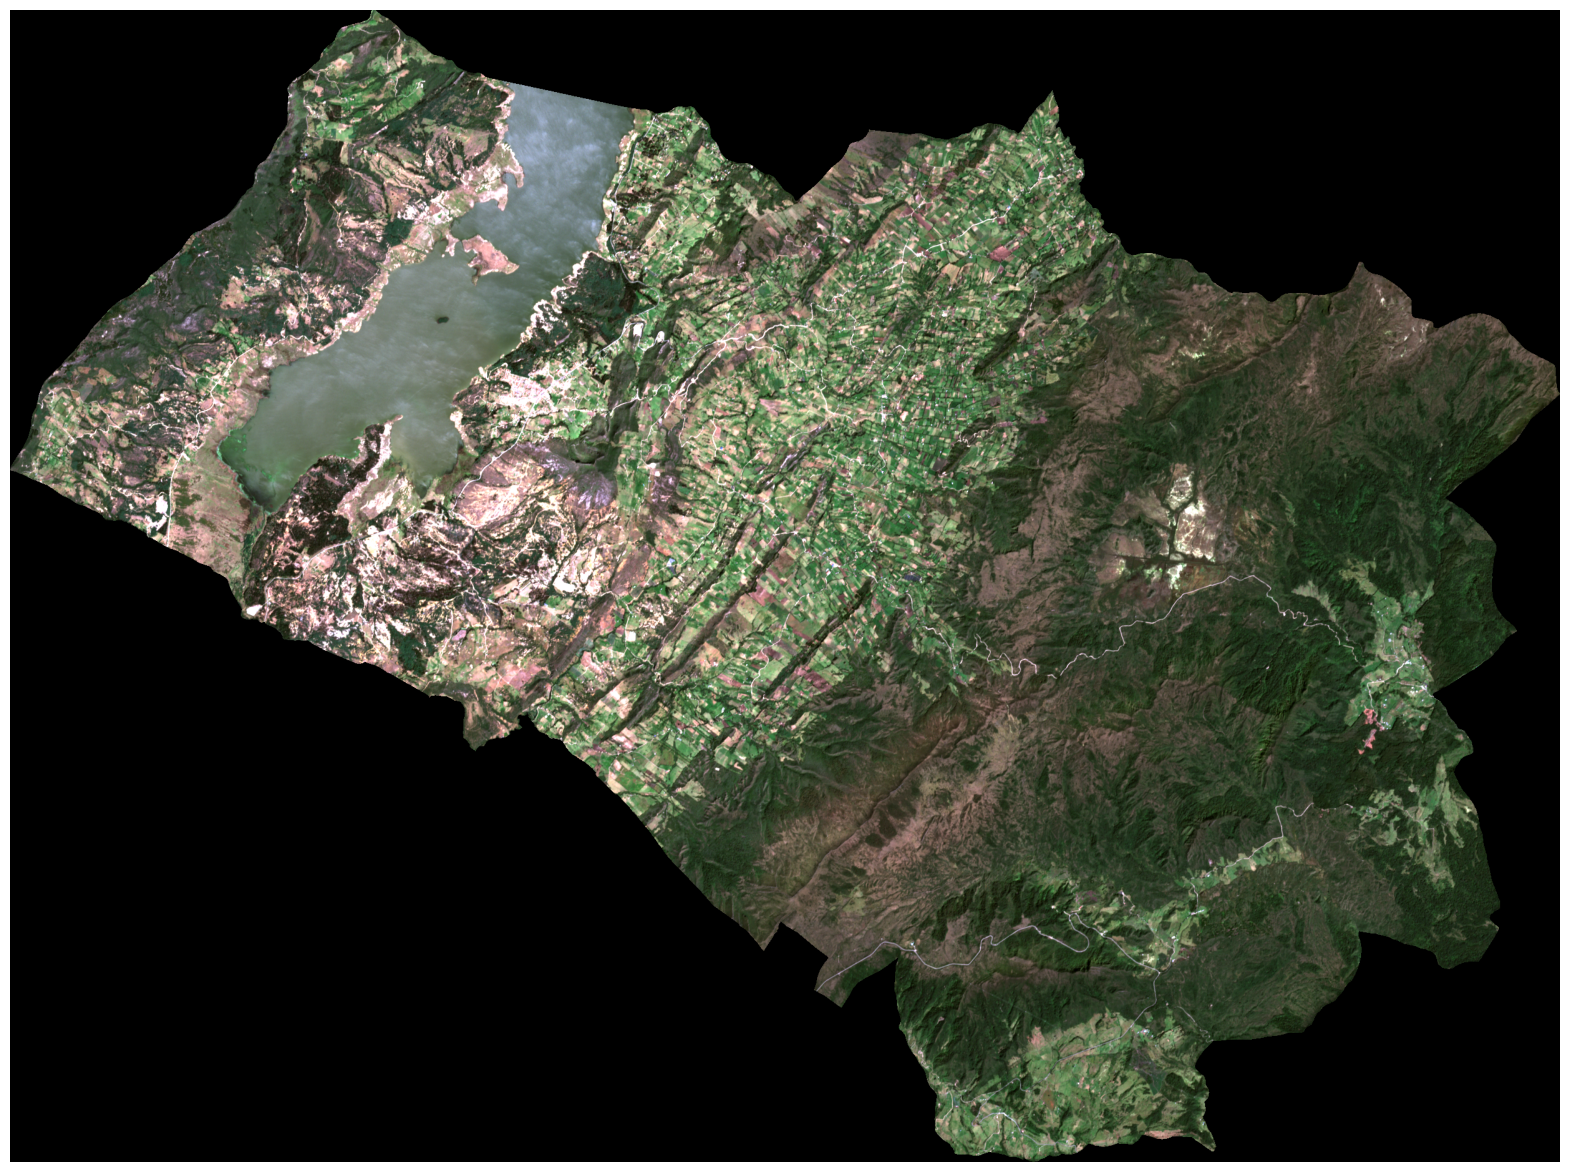

In [4]:
image = cv2.imread('../tiff/sentinel_guatavita_realzada.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Inicializar el modelo GeoSAM
Me da errores la salida 

In [5]:
sam = SamGeo(
    device="cuda",
    hq=True,
    model_type="vit_h",
    checkpoint_dir="../model",
    sam_kwargs={
        "points_per_side": 256,
        "points_per_batch": 64,
        "pred_iou_thresh": 0.5,
        "stability_score_thresh": 0.5,
        "stability_score_offset": 1.0,
        "box_nms_thresh": 0.7,
        "crop_n_layers": 2,
        "crop_nms_thresh": 0.7,
        "crop_overlap_ratio": 0.3,
        "crop_n_points_downscale_factor": 2,
        "point_grids": None,
        "min_mask_region_area": 10,
        "output_mode": "binary_mask"
    },
)

<All keys matched successfully>


## Inicializar el modelo SAMHQ

In [6]:
sam_checkpoint = "../model/sam_hq_vit_h.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side= 324,
    pred_iou_thresh= 0.5,
    stability_score_thresh= 0.2,
    crop_n_layers= 0,
    crop_n_points_downscale_factor= 0,
    min_mask_region_area= 100
)

<All keys matched successfully>


In [7]:
masks = mask_generator.generate(image)


## Visualizar resultado

c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\.venv\Lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


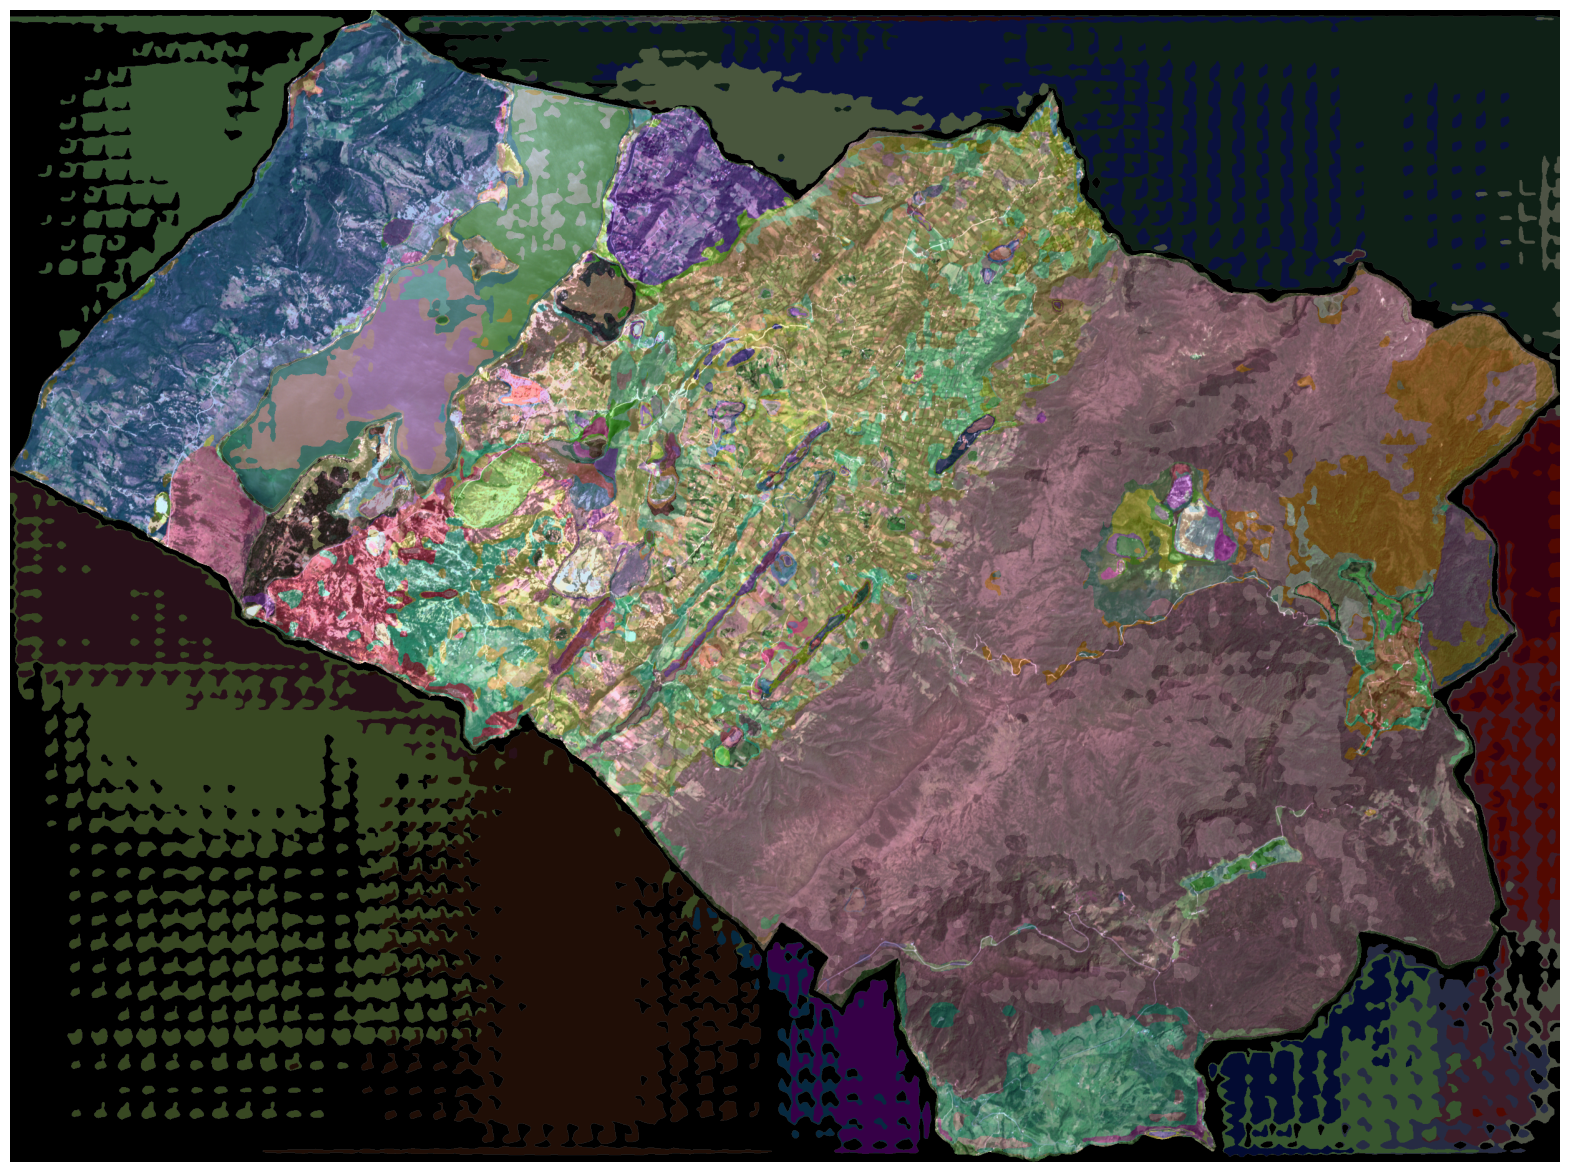

In [ ]:
def show_anns(anns, output_path):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        # Generar una mascara aleatoria
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    # Conversion a uint8 para un rango de 0-255
    img_rgb = (img[:,:,:3] * 255).astype('uint8')
    ## Exportar imagen
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=img.shape[0],
        width=img.shape[1],
        count=3,
        dtype='uint8',
        compress='lzw'
    ) as dst:
        # Guardar cada banda por separado
        dst.write(img_rgb[:,:,0], 1)  # Banda roja
        dst.write(img_rgb[:,:,1], 2)  # Banda verde
        dst.write(img_rgb[:,:,2], 3)  # Banda azul
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks, '../tiff/mascaras_guatavita_realzada.tif')
plt.axis('off')
plt.show()

## Segmentacion automatica por teselas

In [ ]:
sam_checkpoint = "../model/sam_hq_vit_h.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=256,                  
    pred_iou_thresh=0.6,                 
    stability_score_thresh=0.5,          
    box_nms_thresh=0.7,                   
    crop_n_layers=1,                      
    crop_n_points_downscale_factor=1,     
    min_mask_region_area=100,            
    output_mode="binary_mask"
)

<All keys matched successfully>


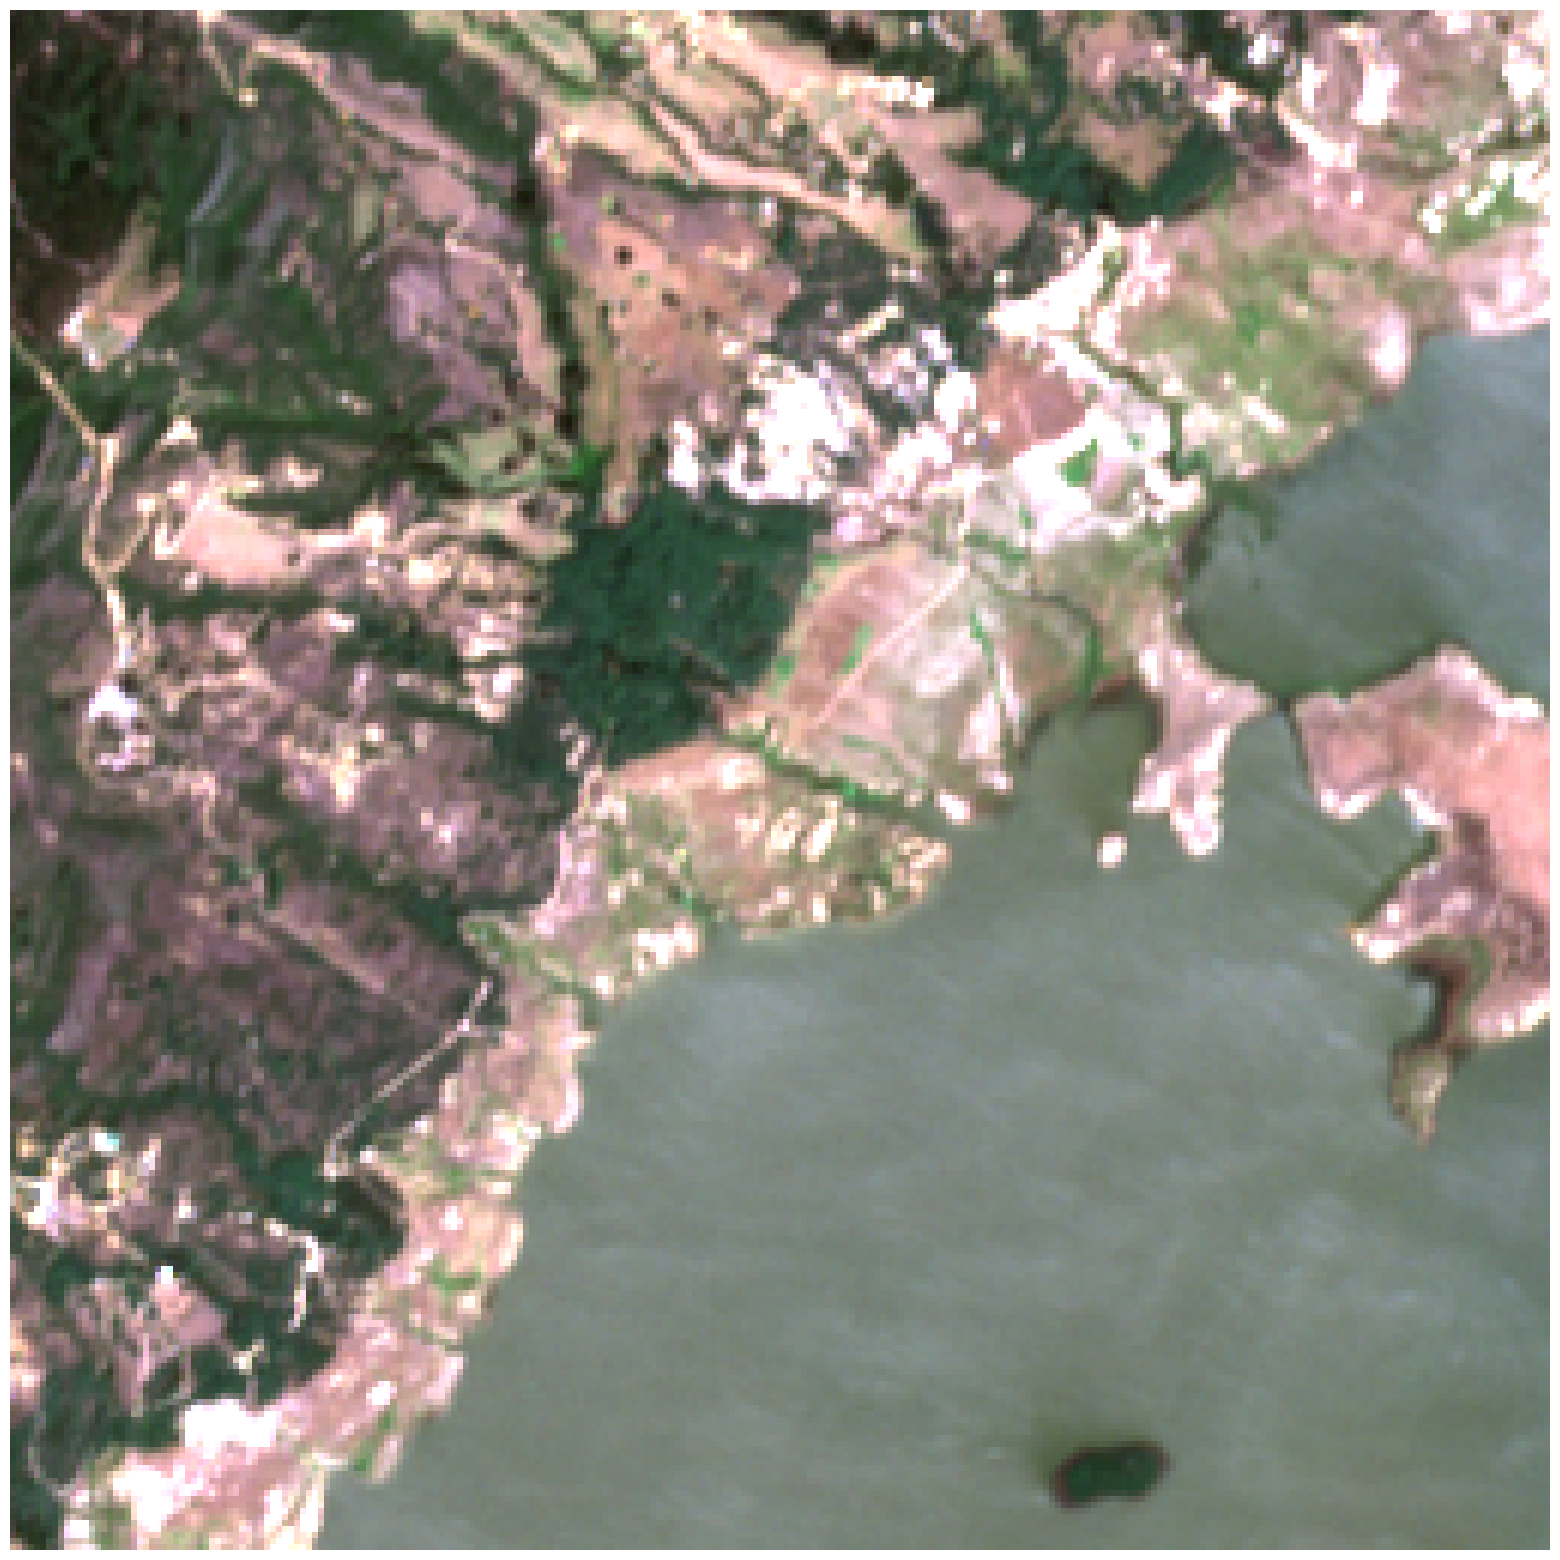

In [22]:
image1 = cv2.imread('../tiles/Sentinel/Guatavita_0_crop.tif')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image1)
plt.axis('off')
plt.show()

In [23]:
masks = mask_generator.generate(image1)

KeyboardInterrupt: 

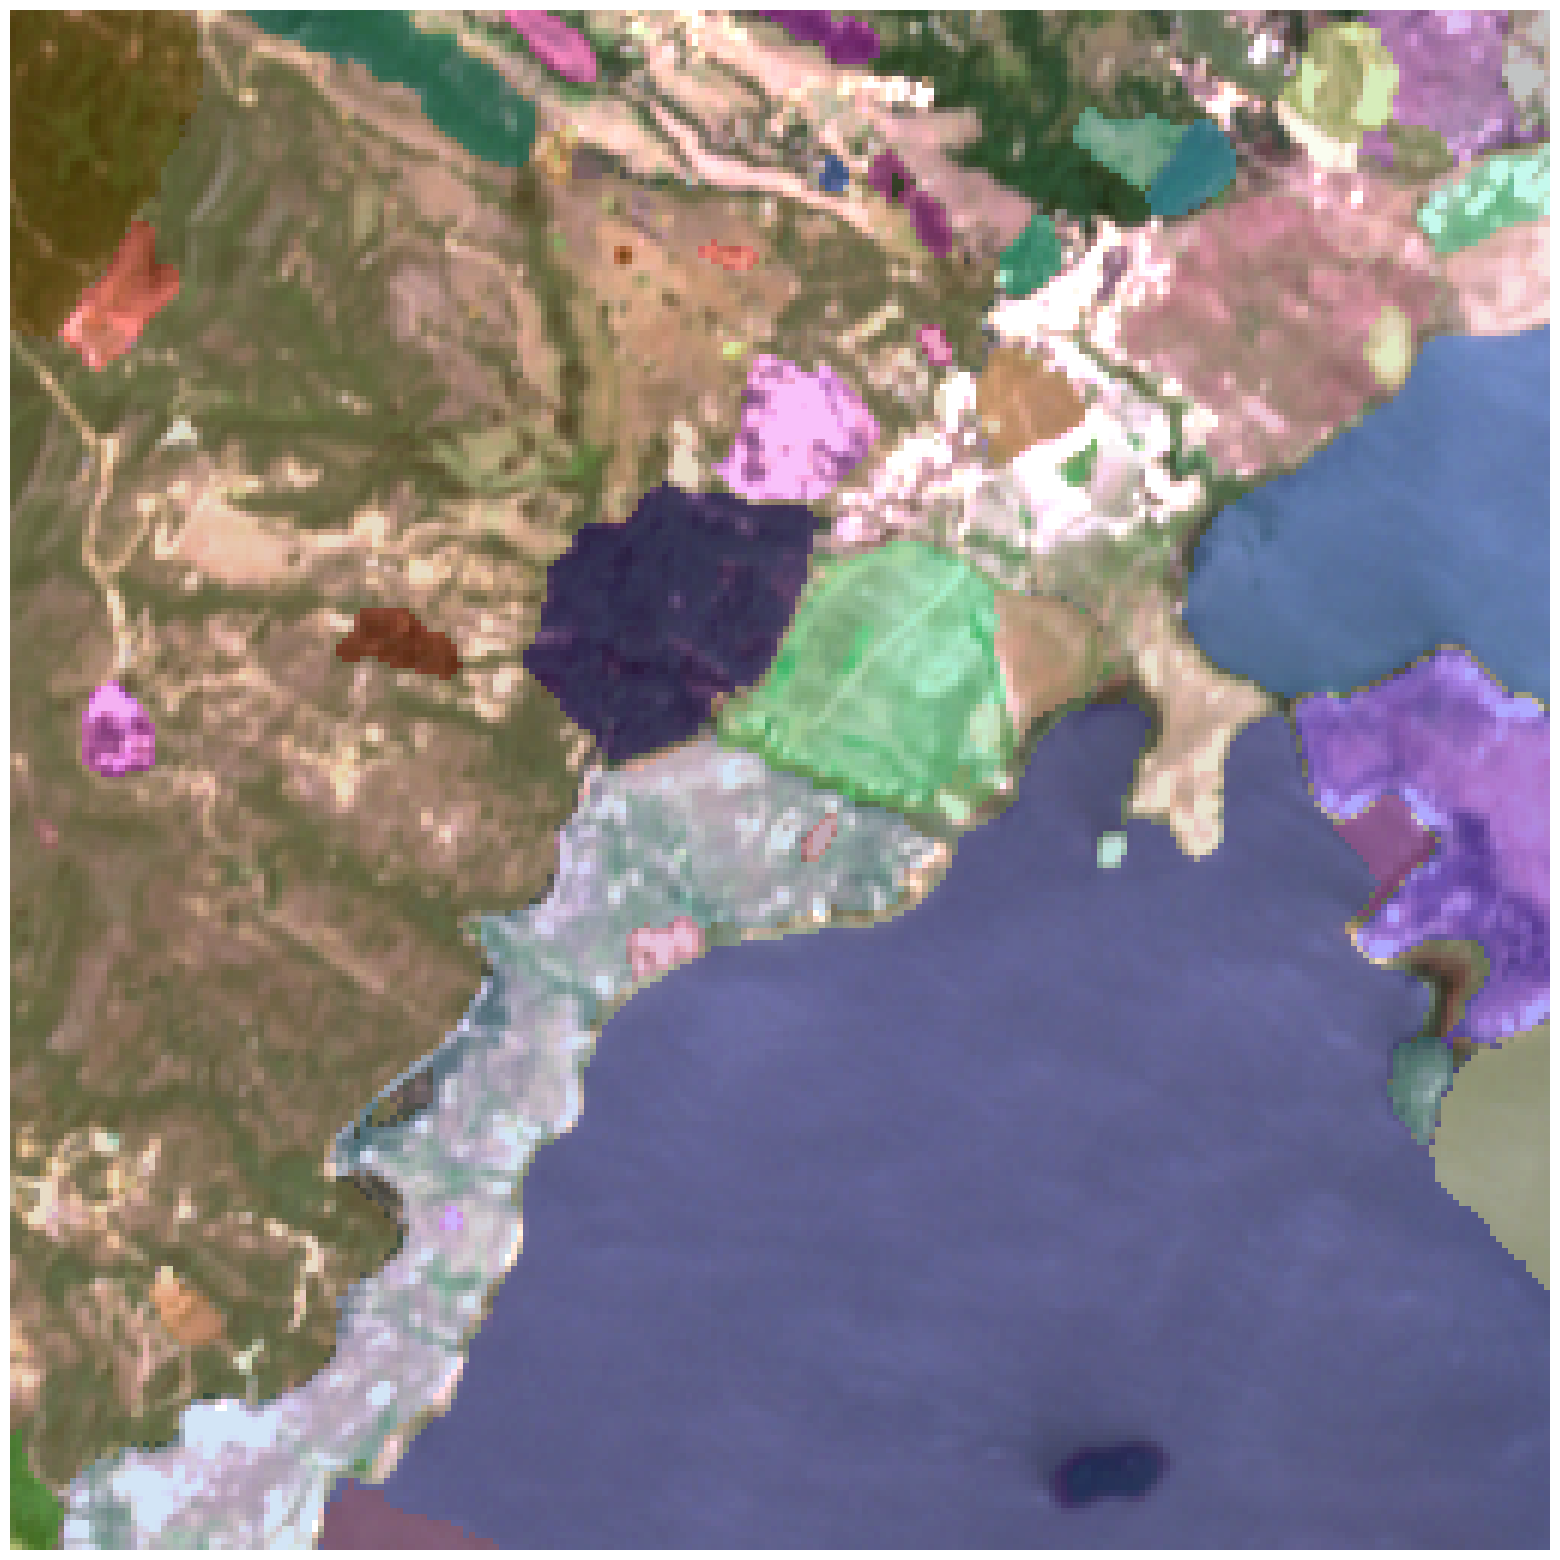

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image1)
show_anns(masks,'../tiles/Segmentation/Guatavita_0_mask.tif')
plt.axis('off')
plt.show()